# Subject:  
. Take into account the selection Algorithm EFSA technique based on filter, embedding and "X" algorithms

. Machine learning techniques  :  **RF**, **Logistic  Regression**,  et **LightGBM**

In [11]:
import pandas as pd
import numpy as np

load data set of Parkinson 

In [12]:
dataset=pd.read_csv('pd_speech_features.csv',header=1)
dataset.shape

(756, 755)

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [14]:
# Check for duplicated rows
dataset[dataset.duplicated()]

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
113,37,0,0.79067,0.58465,0.6425,321,320,0.006004,0.000143,0.00207,...,3.58,4.0251,2.9654,3.8369,4.2973,3.6458,3.1854,3.7708,10.0693,1


In [15]:
dataset.drop_duplicates(inplace=True)
dataset.drop('id',axis=1,inplace=True)
col=dataset.columns
dataset.dropna(inplace=True)

In [16]:
dataset.shape

(755, 754)

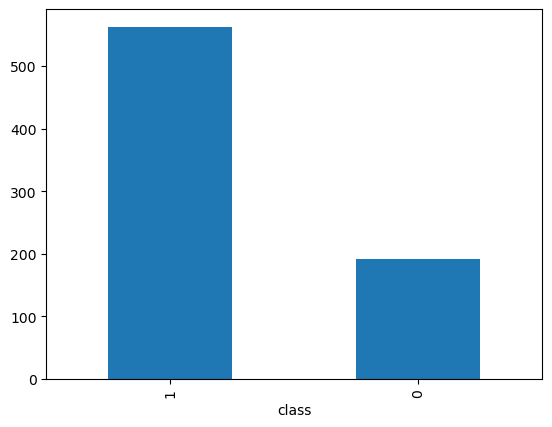

In [17]:
import matplotlib.pyplot as plt
# Check for class imbalance
dataset['class'].value_counts().plot(kind='bar')
plt.show()

In [18]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from decision_tree import DecisionTree
class LightGBM:
    def __init__(self, num_trees=10, max_depth=3, learning_rate=0.1, min_samples_split=10, lambda_=1, num_bins=16, random_seed=None):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.lambda_ = lambda_
        self.num_bins = num_bins
        self.random_seed = random_seed
        self.trees = []
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

    def _compute_gradients(self, y, preds):
        preds = np.clip(preds, 1e-15, 1 - 1e-15)  # Avoid numerical issues
        grad = preds - y
        hess = preds * (1 - preds) + 1e-8  # Add small epsilon for stability
        return grad, hess

    def _grow_tree_with_decision_tree(self, X, grad, hess):
        """
        Use DecisionTree logic to grow a tree for the current stage.
        """
        # Combine gradients and hessians into a pseudo target
        pseudo_target = -grad / (hess + self.lambda_)

        # Convert pseudo-targets into binary labels (or use regression)
        pseudo_target_binary = (pseudo_target > 0).astype(int)

        # Train the DecisionTree with pseudo-targets
        decision_tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        decision_tree.fit(X, pseudo_target_binary)
        return decision_tree

    def fit(self, X, y):
        """
        Train the LightGBM model using DecisionTree for splits.
        """
        self.trees = []
        preds = np.zeros(len(y))  # Initial predictions (log odds)

        for _ in range(self.num_trees):
            grad, hess = self._compute_gradients(y, preds)
            tree = self._grow_tree_with_decision_tree(X, grad, hess)
            self.trees.append(tree)

            # Update predictions with the new tree
            preds += self.learning_rate * np.array([tree._traverse_tree(x, tree.root) for x in X])

    def predict(self, X):
        """
        Predict using the trained model.
        """
        preds = np.zeros(len(X))
        for tree in self.trees:
            preds += self.learning_rate * np.array([tree._traverse_tree(x, tree.root) for x in X])
        return 1 / (1 + np.exp(-preds))  # Convert log odds to probabilities


In [ ]:
from sklearn.model_selection import train_test_split 
lgbm=LightGBM(num_trees=10, max_depth=3, learning_rate=0.1, lambda_=1)

x=dataset.drop('class',axis=1)
y=dataset['class']


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=16)



In [26]:
lgbm.fit(X_train.values,y_train.values)


In [23]:
predic=lgbm.predict(X_test.values)

In [24]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,predic>0.5)
print(f'Accuracy: {accuracy_score(y_test, predic > 0.5)*100:.2f} %')

Accuracy: 83.00 %


In [ ]:
"""
accuracy: 77.60 % 1st run with randomstate 46
Accuracy: 80.40 % second run with randomstate 789
accuracy: 77.60 % 3rd run with randomstate 79
accuracy: 77,60 % 4th run with randomstate 758
accuracy: 80.00 % 5th run with randomstate 16
accuracy: 83.40 % 6th run with randomstate 16
"""

'\n accuracy: 77.60 % 1st run with randomstate 46\n Accuracy: 80.40 % second run with randomstate 789\n accuracy: 77.60 % 3rd run with randomstate 79\n accuracy: 77,60 % 4th run with randomstate 758\n accuracy:  % 5th run with randomstate 16\n'